In [5]:
# --- CELL 1: INSTALLATION ---
# Run this once to set up the environment
#!pip install networkx matplotlib google-generativeai

# --- CELL 2: IMPORTS & SETUP ---
import networkx as nx
import matplotlib.pyplot as plt
#import google.generativeai as genai
import json
import base64
from io import BytesIO

# ==========================================
# 🕒 HOUR 1: THE FOUNDATION (The Map)
# ==========================================

# 1. Define Nodes (Approximate X,Y coordinates based on USF Map)
# Center (0,0) is roughly the Marshall Student Center (MSC)
locations = {
    "Marshall Student Center": (0, 0),
    "USF Library": (0, -2),
    "Bookstore": (-1, 0),
    "Student Services (SVC)": (-1, -1),
    "Chemistry (CHE)": (-2, -1),
    "Interdisciplinary Science (ISA)": (-2, -2),
    "Engineering (ENB)": (-3, 0),
    "Engineering II (ENC)": (-3.2, 0.5),
    "Muma College of Business": (2, -3),
    "Education (EDU)": (1, -1),
    "Cooper Hall (CPR)": (1, -2),
    "Yuengling Center": (5, -1),
    "Recreation Center": (4, 1),
    "Juniper-Poplar Hall": (1, 3),
    "Castor Hall": (0, 2),
    "Fine Arts (FAH)": (-1, 1),
    "Botanical Gardens": (-3, -4),
    "USF Health (MDC)": (-4, 2),
    "Beard Parking Garage": (-3, 2),
    "Collins Blvd Parking": (0, -3)
}

# 2. Define Edges (Connections + Weight in minutes to walk)
# Note: This creates a simplified "connected" campus
edges = [
    ("Marshall Student Center", "Castor Hall", 3),
    ("Marshall Student Center", "Bookstore", 2),
    ("Marshall Student Center", "Student Services (SVC)", 2),
    ("Marshall Student Center", "Engineering (ENB)", 6),
    ("Marshall Student Center", "USF Library", 5),
    ("Marshall Student Center", "Fine Arts (FAH)", 3),
    ("Castor Hall", "Juniper-Poplar Hall", 4),
    ("Juniper-Poplar Hall", "Beard Parking Garage", 5),
    ("Beard Parking Garage", "Engineering (ENB)", 4),
    ("Engineering (ENB)", "Engineering II (ENC)", 1),
    ("Engineering (ENB)", "Recreation Center", 3),
    ("Engineering (ENB)", "Education (EDU)", 4),
    ("Recreation Center", "Yuengling Center", 6),
    ("Yuengling Center", "Muma College of Business", 8),
    ("Muma College of Business", "Cooper Hall (CPR)", 3),
    ("Muma College of Business", "Collins Blvd Parking", 2),
    ("USF Library", "Cooper Hall (CPR)", 2),
    ("USF Library", "Student Services (SVC)", 3),
    ("USF Library", "Collins Blvd Parking", 2),
    ("USF Library", "Interdisciplinary Science (ISA)", 4),
    ("Student Services (SVC)", "Bookstore", 1),
    ("Bookstore", "Chemistry (CHE)", 3),
    ("Chemistry (CHE)", "Interdisciplinary Science (ISA)", 2),
    ("Chemistry (CHE)", "USF Health (MDC)", 6),
    ("Interdisciplinary Science (ISA)", "Botanical Gardens", 8),
    ("Fine Arts (FAH)", "Bookstore", 2),
    ("USF Health (MDC)", "Fine Arts (FAH)", 5)
]

# 3. Build the Graph
G = nx.Graph()
for node, pos in locations.items():
    G.add_node(node, pos=pos)

G.add_weighted_edges_from([(u, v, w) for u, v, w in edges])

print(f"✅ Map Built: {G.number_of_nodes()} Locations, {G.number_of_edges()} Paths.")




✅ Map Built: 20 Locations, 27 Paths.


In [ ]:

# ==========================================
# 🕒 HOUR 2: THE BRAIN (The LLM)
# ==========================================

# 🔑 SETUP: PASTE YOUR API KEY HERE
GOOGLE_API_KEY = "PASTE_YOUR_GEMINI_API_KEY_HERE"
genai.configure(api_key=GOOGLE_API_KEY)

# System Prompt: Defines the "Rules" for the AI
SYSTEM_PROMPT = f"""
You are the navigation brain for USF SmartNav.
Your Job: Convert user text into a structured JSON object.

The user will tell you where they are and what they want.
You must map their vague request to the CLOSEST logical node from this list:
{list(locations.keys())}

Rules:
1. If the start is unknown, default to "Marshall Student Center".
2. If the destination is vague (e.g. "food"), pick the most logical node (e.g. "Marshall Student Center" or "Bookstore").
3. If they mention a class code like "ENC", map it to "Engineering II (ENC)".
4. Return ONLY JSON. No markdown formatting.

Output Format:
{{
  "start_node": "Exact Node Name",
  "target_node": "Exact Node Name",
  "reasoning": "Brief explanation of why you picked this target"
}}
"""

model = genai.GenerativeModel('gemini-1.5-flash', system_instruction=SYSTEM_PROMPT)

def get_navigation_intent(user_query):
    """Sends query to Gemini and parses JSON response"""
    try:
        response = model.generate_content(user_query)
        # Clean response (sometimes models add ```json ... ```)
        clean_text = response.text.replace("```json", "").replace("```", "").strip()
        return json.loads(clean_text)
    except Exception as e:
        print(f"❌ AI Error: {e}")
        return None

# Test the Brain
test_query = "I'm currently at the library and I really need to find a quiet place to study engineering."
print(f"🧠 Testing Query: '{test_query}'")
intent = get_navigation_intent(test_query)
print(f"🤖 AI Output: {intent}")



✅ Map Built: 20 Locations, 27 Paths.
🧠 Testing Query: 'I'm currently at the library and I really need to find a quiet place to study engineering.'


❌ AI Error: 400 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.
🤖 AI Output: None


⚠️ Hour 2 (AI) was skipped. Using DEFAULT test path.

🗺️ Plotting path from Marshall Student Center to USF Library...
✅ Visualization generated! (Base64 String Length: 80540)


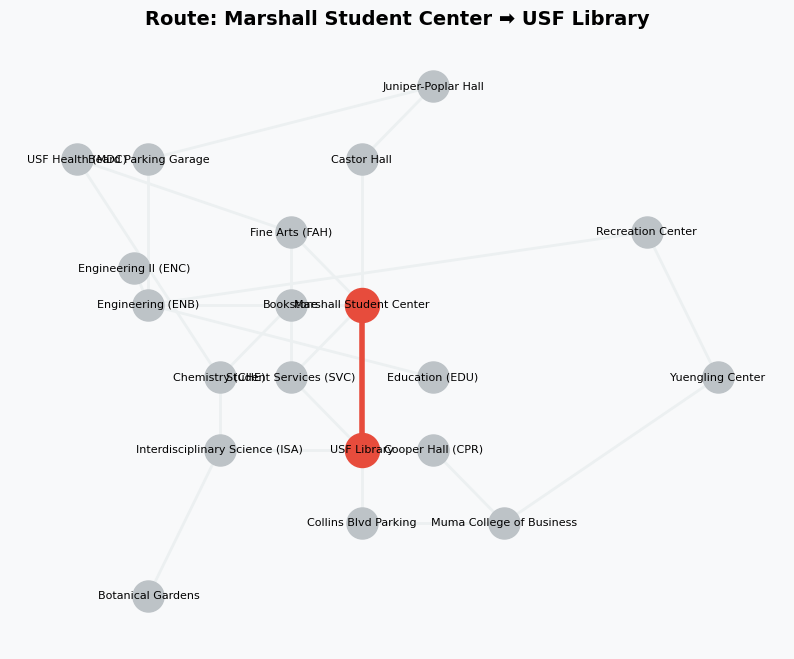

In [6]:



# ==========================================
# 🕒 HOUR 3: THE VISUALIZATION
# ==========================================

def visualize_campus_path(start_node, target_node):
    """
    Calculates shortest path and returns a Base64 Image String
    of the map with the route highlighted.
    """
    # 1. Calculate Shortest Path (Dijkstra/A*)
    try:
        path = nx.shortest_path(G, source=start_node, target=target_node, weight="weight")
        path_edges = list(zip(path, path[1:]))
    except nx.NetworkXNoPath:
        print("❌ No path found!")
        return None

    # 2. Setup Plot
    plt.figure(figsize=(10, 8), facecolor='#f8f9fa')
    pos = nx.get_node_attributes(G, 'pos')

    # Draw all nodes (Light Grey)
    nx.draw_networkx_nodes(G, pos, node_color='#bdc3c7', node_size=500)
    nx.draw_networkx_edges(G, pos, edge_color='#ecf0f1', width=2)
    nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')

    # Draw THE PATH (Bright Red)
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_color='#e74c3c', node_size=600)
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='#e74c3c', width=4)

    plt.title(f"Route: {start_node} ➡ {target_node}", fontsize=14, fontweight='bold')
    plt.axis('off')

    # 3. Save to Base64 String (Memory Buffer)
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', dpi=100)
    plt.close()
    buf.seek(0)
    img_b64 = base64.b64encode(buf.read()).decode('utf-8')

    return img_b64

# --- FINAL TEST RUN ---

# --- FINAL TEST RUN ---

# NOTE: ADDED DEFAULT FALLBACK FOR MANUAL TESTING
# If 'intent' variable does not exist (Hour 2 skipped), use these default values
if 'intent' not in locals() or intent is None:
    print("⚠️ Hour 2 (AI) was skipped. Using DEFAULT test path.")
    start = "Marshall Student Center"
    target = "USF Library"
else:
    # Use the AI's result
    start = intent.get('start_node')
    target = intent.get('target_node')

print(f"\n🗺️ Plotting path from {start} to {target}...")
image_data = visualize_campus_path(start, target)

# This demonstrates the image is ready for HTML injection
if image_data:
    print(f"✅ Visualization generated! (Base64 String Length: {len(image_data)})")

    # To see the image in Colab immediately (Preview):
    from IPython.display import Image, display
    display(Image(data=base64.b64decode(image_data)))